This notebook takes the raw tracks for each observation and finds all crossing tracks and extracts all nessisary assosiated information for population estimates including things like bat size, frame darkness etc. All this information is saved in one dictionary for each observation which can be used in other notebooks for further processing.

In [1]:
import glob
import os

import numpy as np

from bat_functions import threshold_short_tracks
from bat_functions import measure_crossing_bats

Warning, the utm package is not installed and so won't be imported. You will not be able to use the function latlong_dict_to_utm.


In [2]:
# Get the height of the video frames

# This can either be manual set or derived from a loaded image frame

# DERIVED (uncomment two lines below to get height by loading an image file)
# image_file = '.../kasanka-bats/processed/deep-learning/19Nov/BBC/example-frames/19Nov_BBC_obs-ind_40500.jpg'
# frame_height = plt.imread(image_file).shape[0]

# MANUALLY SET (Warning! This value must match the actual frame height in the videos being processed!)
frame_height = 1520

In [3]:
# Used for saving the processed track files
root_folder = "" #".../kasanka-bats/processed/deep-learning"

## Take all tracks found and filter out all that don't cross the count line
Save these crossing tracks seprately so this only has to be run once

In [4]:
def get_all_raw_tracks(day_folders, verbose=True):
    """ Get all raw track files within the list of folders.
    
    This should only be used if using the same file structure that we assume:
    
    - day_folder_1
          camera1
              raw_tracks.npy
          camera2
              raw_tracks.npy
          cameraN
              raw_tracks.npy
    - day_folder_2
          camera1
              raw_tracks.npy
    ...
    
    Args:
        day_folder: list of paths to folders that contain sub folders for each 
            camera. Those subfolders contain raw_tracks.npy files
            
    Return list of full paths to raw_track.npy files
        
    """
    
    all_track_files = []
    for day_folder in day_folders:
        print(day_folder)
        date = os.path.basename(day_folder) 
        track_files = sorted(
            glob.glob(os.path.join(day_folder, '*/raw_tracks.npy'))
        )
        all_track_files.extend(track_files)
    return all_track_files

def save_crossing_tracks_from_raw_tracks(file, out_file, verbose=True):
    """ Save all crossing tracks after preproccesing all tracks in observation.
    
    Args:
        file: full path to a numpy file that is a list of track objects
        out_file: full path where list of crossing tracks should be saved
    
    Nothing is returned
    """
    
    raw_track_list = np.load(file, allow_pickle=True)
    if verbose:
        print(f"{len(raw_track_list)} raw tracks in observation.")
    # Get rid of tracks less than two points long
    tracks_list = threshold_short_tracks(raw_track_list, min_length_threshold=2)
    # Get list of tracks that cross the mid line
    crossing_tracks_list = measure_crossing_bats(tracks_list, 
                                                 frame_height=frame_height)
    if verbose:
        print(f"{len(crossing_tracks_list)} tracks crossing counting line",
              "in observation.")

    np.save(out_file, np.array(crossing_tracks_list, dtype=object))
    
    

In [5]:
# Don't worry if you get the following warning:
# RuntimeWarning: All-NaN slice encountered
#  max_edge = np.nanmax(track['rects'], 1)


# If you use our file structure you can use some of the commented lines below 
# Otherwise just do whatever fits your needs to end up with a list of the raw_track.npy
# files that you want to process as we do in the uncommented part
# Get path to the folders for each observation date
# (Each of these contains folders for each camera which contain 'raw_tracks.npy' etc)
# UNCOMMENT THESE LINES OF CODE TO GET MANY RAW TRACK FILES IF USING OUR FILE SYSTEM
# day_folders = day_folders = sorted(
#     glob.glob('.../kasanka-bats/processed/deep-learning/*Nov')
# )
# raw_track_files = get_all_raw_track_files(day_folders)      

# This is an examples of just manually setting the paths to the raw tracks
raw_track_files = [
    ".../wetransfer_raw_tracks_2023-02-07_1331/raw_tracks_2-Dec-2020_MusolaTower/raw_tracks_2-Dec-2020_MusolaTower.npy",
    ".../wetransfer_raw_tracks_2023-02-07_1331/raw_tracks_26-Nov-2021_MusolaTower/raw_tracks_26-Nov-2021_MusolaTower.npy"
]

verbose = True

for track_file in raw_track_files:
    camera_folder = os.path.dirname(track_file)
    # New file path for the crossing tracks that will be saved
    crossing_track_file = os.path.join(camera_folder, 'crossing_tracks.npy')
    if os.path.exists(crossing_track_file):
        # If the crossing tracks from this camera have already been saved don't
        # re-find them
        continue
    save_crossing_tracks_from_raw_tracks(track_file, crossing_track_file)

129734 raw tracks in observation.


/Users/benkoger/Documents/GitHub/kasanka/bat_functions.py:796: RuntimeWarning: All-NaN slice encountered
  max_edge = np.nanmax(track['rects'], 1)


26542 tracks crossing counting line in observation.
23949 raw tracks in observation.
2407 tracks crossing counting line in observation.


### Visualize some of the crossing tracks (Bonus)
### Required processing continues at the next bolded title

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
c_tracks_file = ".../wetransfer_raw_tracks_2023-02-07_1331/raw_tracks_26-Nov-2021_MusolaTower/crossing_tracks.npy"
tracks = np.load(c_tracks_file, allow_pickle=True)

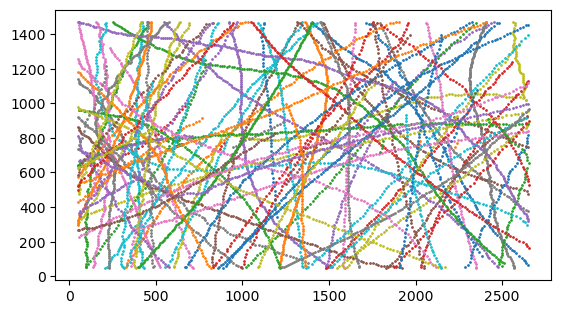

In [13]:
num_tracks = 100

for track_ind in np.linspace(0, len(tracks), num_tracks, endpoint=False, dtype=int):

    track = tracks[track_ind]
    plt.scatter(track['track'][:, 0], track['track'][:, 1], s=1)
    plt.gca().set_aspect('equal')

### For each camera observation on each day, complile all nessisary information about each crossing bat needed to estimate the total population

This expects the file structure to be the same as we use, i.e.

* project_folder
  * date1  
    * camera1  
      * crossing_tracks.npy
      * blue-means.npy
      * ...
    * camera2
      * crossing_tracks.npy
      * blue-means.npy
      * ...
    * ...
  * date2
    * camera1
      * crossing_tracks.npy
      * blue-means.npy
      * ...
    * ...
  * ...
            

In [ ]:
day_folders = sorted(
    glob.glob('.../kasanka-bats/processed/deep-learning/*Nov')
)

observations = {}
for day_folder in day_folders:
    print(day_folder)

    date = os.path.basename(day_folder)
    track_files = sorted(glob.glob(os.path.join(day_folder, '*/crossing_tracks.npy')))
    observations[date] = {}
    
    for track_file in track_files: 
        camera = track_file.split('/')[-2]
        obs = {'date': date,
               'camera': camera,
               }
        crossing_tracks_list = np.load(track_file, allow_pickle=True)
        # Load the frame darkness values as calculated in get-observation-frame-darkness.ipynb
        darkness_means = np.load(os.path.join(day_folder, camera, 'blue-means.npy'))
        passing_bat_frame = []
        passing_bat_size = []
        passing_bat_track_ind = []
        passing_bat_direction = []
        passing_bat_track_id = []
        passing_bat_darkness = []
        passing_track_length = []
        for track_ind, track in enumerate(crossing_tracks_list):
            if track['crossed'] > 0:
                passing_bat_frame.append(track['crossed'])
                passing_bat_size.append(track['mean_wing'])
                passing_bat_track_id.append(track_ind)
                passing_bat_direction.append(1)
                passing_bat_darkness.append(darkness_means[track['crossed']])
                passing_track_length.append(len(track['track']))

            elif track['crossed'] < 0:
                passing_bat_frame.append(track['crossed'])
                passing_bat_size.append(track['mean_wing'])
                passing_bat_track_id.append(track_ind)
                passing_bat_direction.append(-1)
                passing_bat_darkness.append(darkness_means[-track['crossed']])
                passing_track_length.append(len(track['track']))

        obs['frames'] = np.array(passing_bat_frame)
        obs['mean_wing'] = np.array(passing_bat_size)
        obs['ids'] = np.array(passing_bat_track_id)
        obs['direction'] = np.array(passing_bat_direction)
        obs['darkness'] = np.array(passing_bat_darkness)
        obs['track_length'] = np.array(passing_track_length)
        observations[date][camera] = obs
        
# Save the track crossing information for each observation (camera, date)
observation_root = os.path.join(root_folder, 'observations')
for date, day_obs in observations.items():
    day_folder = os.path.join(observation_root, date)
    os.makedirs(day_folder, exist_ok=True)
    for cam_ind, (cam_name, obs) in enumerate(day_obs.items()):
        obs_name = f'{date}-observation-{cam_name}.npy'
        obs_file = os.path.join(day_folder, obs_name)
        np.save(obs_file, obs)